In [1]:
# Import all necesary libraries
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import gammaln
import math

In [2]:
data = pd.read_feather('/Users/ro/Desktop/Undergrad_AM_Thesis/Data/covid_df.feather')
weekly_covid_df = data.groupby([pd.Grouper(key='date', freq='W-SUN')]).agg({
    'confirmed_cases': 'sum',
    'confirmed_deaths': 'sum'
}).reset_index()
print(weekly_covid_df.head())

pop = pd.read_feather('/Users/ro/Desktop/Undergrad_AM_Thesis/Data/INEGI_2020_State_Population.feather')
N = pop['population'].sum()
print('Total Population: ', N)
print('0.01% of Population: ', np.round(0.001*N).astype(int))

        date  confirmed_cases  confirmed_deaths
0 2020-02-23              4.0               0.0
1 2020-03-01             23.0               0.0
2 2020-03-08            131.0               0.0
3 2020-03-15            624.0               0.0
4 2020-03-22           1152.0               6.0
Total Population:  126014024
0.01% of Population:  126014


In [3]:
def BM_SEUORDS(X_in, params, num_particles, m):
    num_steps = m + 1  # Initial step + m observations + final step
    h = 1 / num_steps  # Adjust step size

    # Initialize arrays to store results
    X = np.zeros([X_in.shape[0], num_particles, num_steps + 1])
    Z1 = np.zeros([num_particles, num_steps + 1])
    Z2 = np.zeros([num_particles, num_steps + 1])
    
    new_undetected = np.zeros([num_particles])
    new_observed = np.zeros([num_particles])
    new_deaths = np.zeros([num_particles])

    # Set initial conditions
    alpha, rho, nu, gamma, sigma_b, sigma_m, _, _ = params
    X[:, :, 0] = X_in
    Z1[:, 0] = np.log(X_in[6, :])  # Logit for beta(0)
    Z2[:, 0] = np.log(X_in[7, :])  # Logit for mu(0)

    # Simulate the SIR model with stochastic beta using Euler-Maruyama method
    for t in range(1, num_steps + 1):
        # Sample Brownian increment
        dB1 = stats.norm(0, 1).rvs(num_particles)
        dB2 = stats.norm(0, 1).rvs(num_particles)
        
        # Update Z using Euler-Maruyama method
        Z1[:, t] = Z1[:, t - 1] + sigma_b * dB1 * np.sqrt(h)
        Z2[:, t] = Z2[:, t - 1] + sigma_m * dB2 * np.sqrt(h)
        
        # Update time-varying parameter values
        X[6, :, t] = np.exp(Z1[:, t]) # beta(t)
        X[7, :, t] = np.exp(Z2[:, t]) # mu(t)
        
        # Update SEUORDS model
        X[0, :, t] = X[0, :, t - 1] + (-X[6, :, t] * (X[2, :, t - 1] + X[3, :, t - 1]) * X[0, :, t - 1] / N + alpha * X[4, :, t - 1]) * h     # S-Susceptibles
        X[1, :, t] = X[1, :, t - 1] + (X[6, :, t] * (X[2, :, t - 1] + X[3, :, t - 1]) * X[0, :, t - 1] / N - nu * X[1, :, t - 1]) * h         # E-Exposed
        X[2, :, t] = X[2, :, t - 1] + (rho * nu * X[1, :, t - 1] - gamma * X[2, :, t - 1]) * h                                                # U-Unobserved
        X[3, :, t] = X[3, :, t - 1] + ((1 - rho) * nu * X[1, :, t - 1] - gamma * X[3, :, t - 1] - X[7, :, t] * X[3, :, t - 1]) * h            # O-Observed
        X[4, :, t] = X[4, :, t - 1] + (gamma * (X[2, :, t - 1] + X[3, :, t - 1]) - alpha * X[4, :, t - 1]) * h                                # R-Recovered
        X[5, :, t] = X[5, :, t - 1] + (X[7, :, t] * X[3, :, t - 1]) * h                                                                       # D-Death
        
        new_undetected += (rho * nu * X[1, :, t - 1]) * h
        new_observed += ((1 - rho) * nu * X[1, :, t - 1]) * h
        new_deaths += (X[7, :, t] * X[3, :, t - 1]) * h   
    
    return X, new_observed, new_deaths, new_undetected

In [4]:
# Create NB log-likelihood function
def NB_log_likelihood(y, mu, psi):
    # Add a small positive constant to avoid numerical instability
    mu = np.maximum(mu, 1e-10)
    psi = np.maximum(psi, 1e-10)
    aux = np.maximum(mu + psi, 1e-10)
    
    return gammaln(y + psi) - gammaln(y+1) - gammaln(psi) + y * (np.log(mu) - np.log(aux)) + psi * (np.log(psi) - np.log(aux))

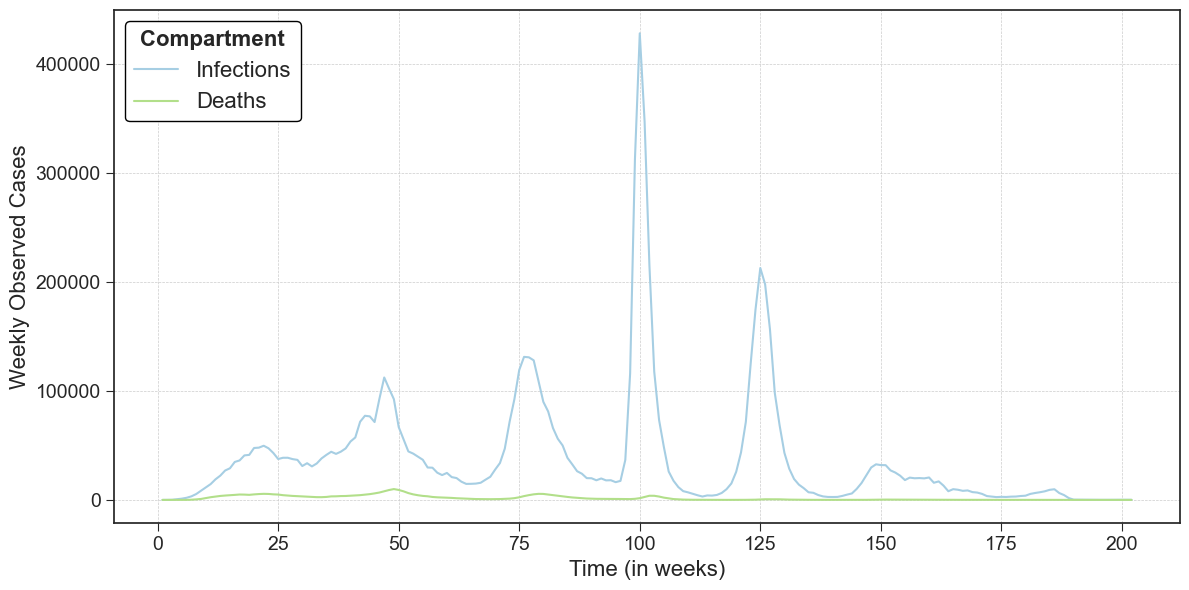

In [205]:
# Define subset of data to run the algorithm 
weeks = 202

YO = weekly_covid_df['confirmed_cases'].values[:weeks]
YD = weekly_covid_df['confirmed_deaths'].values[:weeks]

time = np.linspace(1, weeks, weeks)

plt.figure(figsize=(12,6))
plt.style.use('seaborn-v0_8-ticks')
colors = sns.color_palette('Paired')

plt.plot(time, YO, color=colors[0], label='Infections')
plt.plot(time, YD, color=colors[2], label='Deaths')

plt.legend(
    loc='upper left',
    fontsize=16, 
    title='Compartment', 
    title_fontproperties={'weight': 'bold', 'size': 16},
    frameon=True,                  
    fancybox=True,                 
    framealpha=1,                   
    edgecolor='black',              
    facecolor='white')

plt.grid(visible=True, linestyle='--', linewidth=0.5)  
plt.xlabel('Time (in weeks)', fontsize=16)
plt.ylabel('Weekly Observed Cases', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.grid(visible=True, linestyle='--', linewidth=0.5)  
plt.tight_layout()
plt.show()

In [243]:
# Initial Value Conditions Prior
def set_IVC(N, num_particles):
    R = np.zeros(num_particles)
    D = np.zeros(num_particles)
    E = stats.uniform(0, 1000).rvs(num_particles)
    U = stats.uniform(0, 1000).rvs(num_particles)      
    O = np.ones(num_particles) * 4 
    S = N - E - U - O
    
    beta = stats.uniform(0,10).rvs(num_particles)
    mu = stats.uniform(0,10).rvs(num_particles)
    
    return np.vstack([S, E, U, O, R, D, beta, mu])

def set_param_priors():
    alpha = stats.beta(2.3, 96.5).rvs()
    rho = stats.beta(7.2, 0.8).rvs()
    nu = stats.beta(6.9, 14.1).rvs()
    gamma = stats.beta(2.36, 9.44).rvs()
    sigma_b = stats.invgamma(a=3.8, scale=0.6).rvs()
    sigma_m = stats.invgamma(a=3.8, scale=0.6).rvs()
    psi_o = stats.uniform(0, 100).rvs() #stats.gamma(50,scale=100).rvs()
    psi_d = stats.uniform(0, 100).rvs() #stats.gamma(50,scale=100).rvs() 
    
    return [alpha, rho, nu, gamma, sigma_b, sigma_m, psi_o, psi_d]

In [230]:
T =  weeks - 1
m = 10
num_steps = m + 1
total_steps = T * num_steps 
num_particles = 5000

params = set_param_priors()
initial_conditions = set_IVC(N, num_particles)

# Initialize PF variables
state_estimates = np.zeros([3, T+1])
particles = np.zeros([initial_conditions.shape[0], num_particles, total_steps + 1]) 
weekly_aggregates = np.zeros([3, num_particles, T+1])

weights = np.zeros([num_particles, T+1])
norm_weights = np.zeros([num_particles, T+1])

ancestry_matrix = np.zeros([num_particles, T+1])
ESS = np.zeros(T+1)
loglikelihood = 0

# Define values at time t=0
particles[:, :, 0] = initial_conditions
original_particles = particles.copy()
weekly_aggregates[0,:,0] = particles[3, :, 0]
weekly_aggregates[1,:,0] = particles[5, :, 0]
weekly_aggregates[2,:,0] = particles[2, :, 0]

incremental_weights = NB_log_likelihood(YO[0], weekly_aggregates[0,:,0], params[6]) + NB_log_likelihood(YD[0], weekly_aggregates[1,:,0], params[7]) 
max_weights = np.max(incremental_weights)
weights[:,0] = np.exp(incremental_weights - max_weights)
sum_weights = weights[:,0].sum()
norm_weights[:,0] = weights[:,0] / sum_weights

start_idx = 0
for t in range(1,T+1):
    

IndentationError: expected an indented block (2667301399.py, line 37)

In [258]:
(0.5 < 0)*25

0

In [253]:
T =  weeks - 1
m = 10
num_steps = m + 1
total_steps = T * num_steps 
num_particles = 1000

params = set_param_priors()
initial_conditions = set_IVC(N, num_particles)

# Initialize PF variables
state_estimates = np.zeros([3, T+1])
particles = np.zeros([initial_conditions.shape[0], num_particles, total_steps + 1]) 
resampled_partices = np.zeros([initial_conditions.shape[0], num_particles, total_steps + 1]) 
weekly_aggregates = np.zeros([3, num_particles, T+1])
weights = np.zeros([num_particles, T+1])
norm_weights = np.zeros([num_particles, T+1])
ancestry_matrix = np.zeros([num_particles, T+1])
ESS = np.zeros(T+1)
loglikelihood = 0

# Define values at time t=0
particles[:, :, 0] = initial_conditions
original_particles = particles.copy()
weekly_aggregates[0,:,0] = particles[3, :, 0]
weekly_aggregates[1,:,0] = particles[5, :, 0]
weekly_aggregates[2,:,0] = particles[2, :, 0]

incremental_weights = NB_log_likelihood(YO[0], weekly_aggregates[0,:,0], params[6]) + NB_log_likelihood(YD[0], weekly_aggregates[1,:,0], params[7]) 
max_weights = np.max(incremental_weights)
weights[:,0] = np.exp(incremental_weights - max_weights)
sum_weights = weights[:,0].sum()
norm_weights[:,0] = weights[:,0] / sum_weights
    
ESS[0] = 1 / (np.sum(norm_weights[:,0]**2))
loglikelihood += max_weights + np.log(np.sum(weights[:,0])) - np.log(num_particles)
state_estimates[:,0] = np.sum(weekly_aggregates[:,:,0]*norm_weights[:,0], axis=1)

r = stats.uniform(0,1).rvs()
positions =  (np.arange(num_particles) + r )/num_particles
resample_indices = np.searchsorted(np.cumsum(norm_weights[:,0]), positions)
    
ancestry_matrix[:,0] = resample_indices
    
start_idx = 0
for t in range(1,T+1):
    # Propagate particles to next week
    weekly_results, new_observed, new_deaths, new_undetected = BM_SEUORDS(particles[:, ancestry_matrix[:,t-1].astype(int), start_idx], params, num_particles, m)
    weekly_aggregates[:,:,t] = np.stack((new_observed, new_deaths, new_undetected), axis=0)
    
    # Store updated particle values
    end_idx = start_idx + num_steps    
    particles[:, :, start_idx+1:end_idx+1] = weekly_results[:, :, 1:] 
    original_particles[:, :, start_idx+1:end_idx+1] = weekly_results[:, :, 1:] 
    
    # Update particle weights and resample
    incremental_weights = NB_log_likelihood(YO[t], weekly_aggregates[0,:,t], params[6]) + NB_log_likelihood(YD[t], weekly_aggregates[1,:,t], params[7]) 
    max_weights = np.max(incremental_weights)
    weights[:,t] = np.exp(incremental_weights - max_weights)
    sum_weights = weights[:,t].sum()
    norm_weights[:,t] = weights[:,t] / sum_weights
    
    ESS[t] = 1 / (np.sum(norm_weights[:,t]**2))
    loglikelihood += max_weights + np.log(np.sum(weights[:,t])) - np.log(num_particles)
    if np.isnan(loglikelihood):
        break
    state_estimates[:,t] = np.sum(weekly_aggregates[:,:,t]*norm_weights[:,t], axis=1)
    
    # Systematic resampling
    r = stats.uniform(0,1).rvs()
    positions =  (np.arange(num_particles) + r )/num_particles
    resample_indices = np.searchsorted(np.cumsum(norm_weights[:,t]), positions)
    
    ancestry_matrix[:,t] = resample_indices
        
    start_idx = end_idx
    
print(loglikelihood)

-19942.963498233516


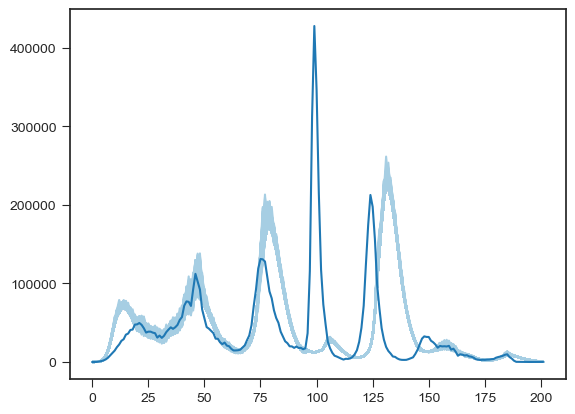

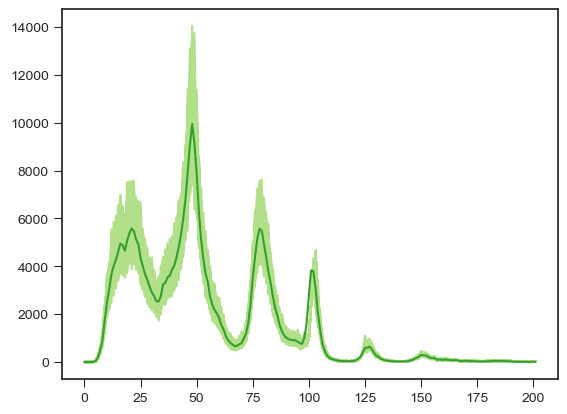

In [254]:
for p in range(num_particles):
    plt.plot(weekly_aggregates[0, ancestry_matrix[p, :].astype(int), np.arange(T + 1)], color=colors[0])
plt.plot(YO, color=colors[1])
plt.show()

for p in range(num_particles):
    plt.plot(weekly_aggregates[1, ancestry_matrix[p, :].astype(int), np.arange(T + 1)], color=colors[2])
plt.plot(YD, color=colors[3])
plt.show()

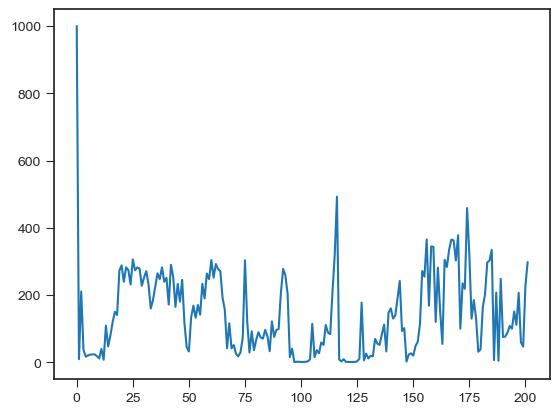

In [255]:
plt.plot(ESS)